In [1]:
import pandas as pd
import re
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import string
import math
import os

from tqdm.auto import tqdm
from collections import Counter
from torch.utils.data import DataLoader, Subset, Dataset
from torch import nn

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FinalBalancedDataset.csv")
data.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [3]:
data[data.Toxicity==1]

,Unnamed: 0,Toxicity,tweet
13,13,1,@user #cnn calls #michigan middle school 'buil...
14,14,1,no comment! in #australia #opkillingbay #se...
17,17,1,retweet if you agree!
23,23,1,@user @user lumpy says i am a . prove it lumpy.
34,34,1,it's unbelievable that in the 21st century we'...
...,...,...,...
56739,56739,1,you're such a retard i hope you get type 2 dia...
56740,56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,56741,1,"you've gone and broke the wrong heart baby, an..."
56742,56742,1,young buck wanna eat!!.. dat nigguh like I ain...


In [4]:
data.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [5]:
data["Toxicity"].value_counts()

Toxicity
0    32592
1    24153
Name: count, dtype: int64

In [6]:
def remove_non_english(df, column_name):
    def contains_non_english(text):
        return any(char.isalpha() and not char.isascii() for char in text)

    non_english_mask = df[column_name].apply(contains_non_english)

    # delete rows that contains not eng digits
    df_filtered = df[~non_english_mask]

    return df_filtered

data = remove_non_english(data, 'tweet')
data['Toxicity'].value_counts()

Toxicity
1    23353
0    22636
Name: count, dtype: int64

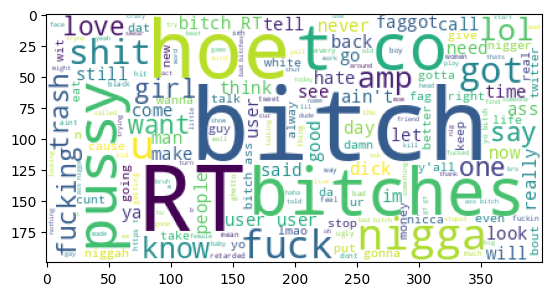

In [7]:
def create_word_cloude(dataset, target):
  words = []
  for tweet in dataset[dataset['Toxicity'] == target].tweet.str.split():
    for word in tweet:
      words.append(word)

  return words

words_1 = create_word_cloude(data, 1)
words_0 = create_word_cloude(data, 0)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud_1 = WordCloud(background_color='white', max_font_size=80).generate(' '.join(words_1))
plt.imshow(word_cloud_1)

In [8]:
MAX_LEN = 1024
# Use these many top words from the dataset. If -1, use all words.
NUM_WORDS = 32000 # Vocabulary size.
# Batch size.
BATCH_SIZE = 32
VALID_SPLIT = 0.15
EPOCHS = 30
LR = 0.005

In [9]:
def find_longest_length(dataset, column: str):

    max_length = 0

    for row in dataset[column]:
        if len(row) > max_length:
            max_length = len(row)

    return max_length

find_longest_length(data, "tweet")

754

In [10]:
def find_avg_sentence_length(dataset, column: str):

    sentence_lengths = []

    for row in data[column]:
        corpus = [
          word for word in row.split()
        ]

        sentence_lengths.append(len(corpus))

    return sum(sentence_lengths)/len(sentence_lengths)

find_avg_sentence_length(data, 'tweet')

13.630759529452694

In [11]:
def find_word_frequency(dataset, column: str, most_common=None):

  words = []

  for row in dataset[column]:
    words.extend([word for word in row.split()])

  count_words = Counter(words)
  word_frequency = count_words.most_common(n=most_common)

  return word_frequency

find_word_frequency(data[data.Toxicity == 1], 'tweet')

[('a', 8612),
 ('bitch', 6641),
 ('RT', 6594),
 ('I', 5821),
 ('the', 5759),
 ('to', 4870),
 ('you', 4852),
 ('and', 3292),
 ('that', 2972),
 ('my', 2886),
 ('in', 2674),
 ('is', 2582),
 ('bitches', 2576),
 ('like', 2392),
 ('of', 2262),
 ('be', 2254),
 ('on', 2197),
 ('me', 2101),
 ('hoes', 1925),
 ('for', 1807),
 ('pussy', 1712),
 ('with', 1637),
 ('this', 1518),
 ('hoe', 1465),
 ('ass', 1449),
 ("I'm", 1382),
 ('your', 1376),
 ('it', 1345),
 ('get', 1269),
 ('up', 1238),
 ("don't", 1204),
 ('@user', 1188),
 ('just', 1167),
 ('but', 1166),
 ('got', 1143),
 ('all', 1136),
 ('they', 1118),
 ('u', 1103),
 ('fuck', 1083),
 ('so', 1059),
 ('her', 1024),
 ('was', 1017),
 ('shit', 1003),
 ('these', 1002),
 ('are', 987),
 ('not', 967),
 ('nigga', 967),
 ('no', 966),
 ('at', 937),
 ('when', 923),
 ('have', 918),
 ('she', 915),
 ('i', 910),
 ('out', 882),
 ('about', 876),
 ("ain't", 835),
 ('if', 834),
 ('&amp;', 828),
 ('some', 714),
 ('You', 698),
 ('know', 697),
 ('do', 688),
 ('he', 687),


In [12]:
def word2int(input_words: list, num_words: int) -> dict:
    """
    input_words format: [('go, 2'), ('hello', 1)]

    num_words: number of words to use from input_words list, if -1 use all words
    """
    if num_words > -1:
        int_mapping = {
            w: i+1 for i, (w, _) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w: i+1 for i, (w, c) in enumerate(input_words)}

    return int_mapping

In [13]:
class NLPClassificationDataset(Dataset):
  def __init__(self, tweets, labels, word_frequency, int_mapped, max_len):
    self.word_frequency = word_frequency
    self.int_mapped = int_mapped
    self.tweets = tweets.tolist()
    self.labels = labels.tolist()
    self.max_len = max_len

  def int_vector(self, int_mapped, tweet):

    int_vector = [
        int_mapped[word] for word in tweet.split() if word in int_mapped
    ]

    return int_vector

  def pad_features(self, int_vector, max_len):
      features = np.zeros((1, max_len), dtype = int)

      if len(int_vector) <= max_len:
          zeros = list(np.zeros(max_len - len(int_vector)))
          new = zeros + int_vector
      else:
          new = int_vector[: max_len]

      features = np.array(new)

      return features

  def __len__(self):
      return len(self.tweets)

  def __getitem__(self, idx):
      tweet = self.tweets[idx]
      int_vector = self.int_vector(self.int_mapped, tweet)
      padded_features = self.pad_features(int_vector, self.max_len)
      label = self.labels[idx]
      return {
          'text': torch.tensor(padded_features, dtype=torch.int32),
          'label': torch.tensor(label, dtype=torch.long)
        }

In [14]:
word_frequency = find_word_frequency(data, "tweet")

In [15]:
int_mapped = word2int(word_frequency, num_words=NUM_WORDS)

In [16]:
train_tweets, train_labels = data.tweet, data.Toxicity

dataset = NLPClassificationDataset(train_tweets, train_labels, word_frequency, int_mapped, MAX_LEN)

dataset_size = len(dataset)
val_size = int(dataset_size * VALID_SPLIT)

indices = torch.randperm(len(dataset)).tolist()

dataset_train = Subset(dataset, indices[:-val_size])
dataset_val = Subset(dataset, indices[-val_size:])

print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_val)}")


Number of training samples: 39091
Number of validation samples: 6898


In [17]:
# class data_set(Dataset):
#     def __init__(self):
#         numbers = list(range(0, 100, 1))
#         self.data = numbers

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         return self.data[index]


# dataset = data_set()

# # implementing dataloader on the dataset and printing per batch
# dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
# for i, batch in enumerate(dataloader):
#     print(i, batch)

In [18]:
train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
valid_loader = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

# for i, (x, y) in enumerate(train_loader):
#   print(i, x, y)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
def calc_correct_uncorrect(labels, outputs, train_running_corr):

  outputs = torch.sigmoid(outputs)
  running_correct = 0

  for i, label in enumerate(labels):
    if label < 0.5 and outputs[i] < 0.5:
        running_correct += 1
    elif label >= 0.5 and outputs[i] >= 0.5:
        running_correct += 1

  return running_correct


In [20]:
def binary_accuracy(labels, outputs, train_running_correct):
    # As the outputs are currently logits.
    outputs = torch.sigmoid(outputs)
    running_correct = 0
    for i, label in enumerate(labels):
        if label < 0.5 and outputs[i] < 0.5:
            running_correct += 1
        elif label >= 0.5 and outputs[i] >= 0.5:
            running_correct += 1
    return running_correct

In [21]:
def train(model, trainloader, optimizer, criterion, device):

    model.train()
    print('Training')

    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):

        counter += 1
        inputs, labels = data['text'], data['label']
        inputs = inputs.to(device)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)
        optimizer.zero_grad()

        # Forward pass.
        outputs = model(inputs)
        outputs = torch.squeeze(outputs, -1)

        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        running_correct = binary_accuracy(
            labels, outputs, train_running_correct
        )
        train_running_correct += running_correct

        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [22]:
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, labels = data['text'], data['label']
            inputs = inputs.to(device)
            labels = torch.tensor(labels, dtype=torch.float32).to(device)

            # Forward pass.
            outputs = model(inputs)
            outputs = torch.squeeze(outputs, -1)

            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            running_correct = binary_accuracy(
                labels, outputs, valid_running_correct
            )

            valid_running_correct += running_correct

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [23]:
EMBED_DIM = 256
NUM_ENCODER_LAYERS = 3
NUM_HEADS = 4

In [24]:
class EncoderClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_layers, num_heads, drp=0.2):
    super(EncoderClassifier, self).__init__()
    self.emb = nn.Embedding(vocab_size, embed_dim)
    self.encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim,
        nhead=num_heads,
        batch_first=True
    )
    self.encoder = nn.TransformerEncoder(
        encoder_layer=self.encoder_layer,
        num_layers=num_layers
    )
    self.linear = nn.Linear(embed_dim, 1)
    self.dropout = nn.Dropout(drp)

  def forward(self, x):
    x = self.emb(x)
    x = self.encoder(x)
    x = self.dropout(x)

    x = x.max(dim=1)[0]
    out = self.linear(x)

    return out


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EncoderClassifier(
    len(int_mapped)+1,
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)

print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())

print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)

print(f"{total_trainable_params:,} training parameters.\n")

EncoderClassifier(
  (emb): Embedding(32001, 256)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=LR,
)

In [ ]:
epochs = 100
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    torch.save(model, os.path.join("/content/drive/MyDrive/Colab Notebooks", 'model.pth'))

    print('-'*50)

[INFO]: Epoch 1 of 100
Training


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1222 [00:00<?, ?it/s]

<ipython-input-21-53b4adde928a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


In [ ]:
def show_plots(train_acc, valid_acc, train_loss, valid_loss):
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_plots(train_acc, valid_acc, train_loss, valid_loss)